In [1]:
import numpy as np 
import pandas as pd
import librosa
import matplotlib.pylab as plt
import IPython.display as ipd
from PIL import Image
import math

import torch
import torch.nn as nn
from torch.optim import Adam

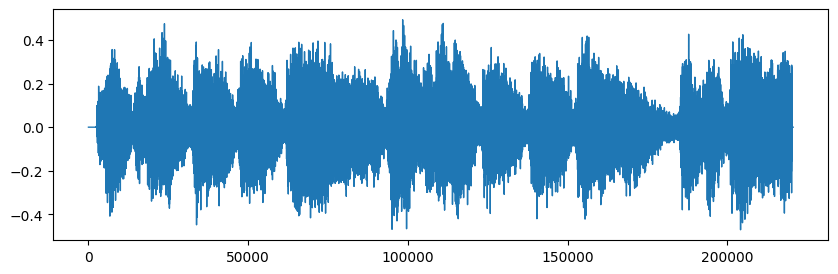

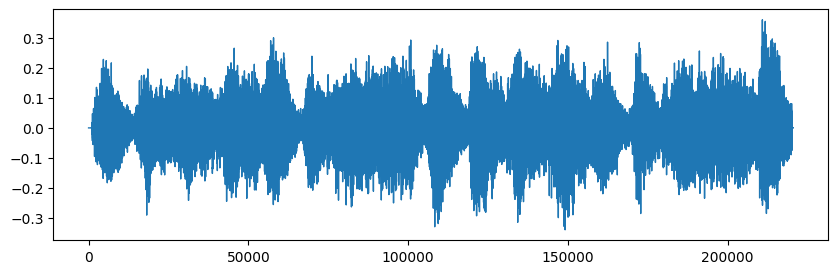

In [2]:
content_path = "input_audio/USA Anthem.mp3"
style_path = "input_audio/Imperial March Starwars.mp3"
seed = 25
def audio_loader(path):
    audio, sr = librosa.load(path)
    if audio.__len__()>=220500:
        audio = audio[:220500] 
    display(ipd.Audio(audio, rate=22050))
    pd.Series(audio).plot(figsize=(10,3), lw=1)
    plt.show()
    return audio, sr

content, sr = audio_loader(content_path)
style, _ = audio_loader(style_path)
size = (1025, 430)

In [3]:
def Audio_transform(aud, size):
    stft = librosa.stft(aud)
    mag, _ = librosa.magphase(stft)  
    mag = np.log1p(mag)

    mag_min, mag_max = mag.min(), mag.max()
    mag_norm = (mag - mag_min) / (mag_max - mag_min)
    mag_norm = mag_norm[:size[0], :size[1]]
    return mag_norm , mag_min, mag_max

def Img_from_aud(mag_norm):
    data = (mag_norm * 255).astype(np.uint8)
    img = Image.fromarray(data, mode='L')
    return img

def Image_to_Audio(img, mag_min, mag_max):
    mag_norm = np.array(img, dtype=np.float32) / 255
    mag = mag_norm * (mag_max - mag_min) + mag_min
    mag = np.exp(mag) - 1
    return librosa.griffinlim(mag)

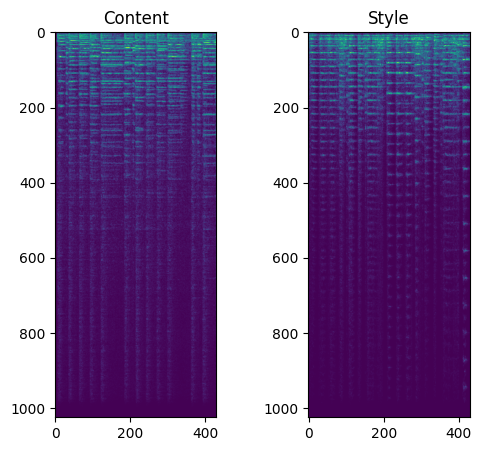

In [4]:
content_norm, mag_min, mag_max= Audio_transform(content,size)
content_img = Img_from_aud(content_norm)
style_norm, _, _= Audio_transform(style, size)
style_img = Img_from_aud(style_norm)

content_array = np.array(content_img).T[None, None, :, :]
style_array = np.array(style_img).T[None, None, :, :]
content_tensor = torch.tensor(content_array, dtype=torch.float32)
style_tensor = torch.tensor(style_array, dtype=torch.float32)

plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content_img)
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style_img)
plt.show()

In [5]:
print(content_tensor.shape)
BATCH, CHANNELS, HEIGHT, WIDTH = content_tensor.shape
FILTERS = 4096
input_shape = (CHANNELS, HEIGHT, WIDTH)

torch.Size([1, 1, 430, 1025])


In [6]:
def custom_kernel_initializer(shape):
    std = np.sqrt(2) * np.sqrt(2.0 / ((CHANNELS + FILTERS) * 11))
    kernel = torch.randn(1, 1, shape[-2], shape[-1]) * std
    torch.manual_seed(seed)
    return nn.Parameter(kernel)

class ShalRandNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_initializer):
        super(ShalRandNet, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(1, 11),
            padding='same',
            bias=False
        )
        print(self.conv.weight.shape)
        self.conv.weight.data = kernel_initializer(self.conv.weight.shape)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    

model = ShalRandNet(CHANNELS, FILTERS, custom_kernel_initializer)
print(model)

torch.Size([4096, 1, 1, 11])
ShalRandNet(
  (conv): Conv2d(1, 4096, kernel_size=(1, 11), stride=(1, 1), padding=same, bias=False)
  (relu): ReLU()
)


In [7]:
def gram_matrix(x):
    ftr = torch.reshape(x,(-1,x.shape[-1]))
    gram = torch.matmul(ftr.t(), ftr)
    return gram


def get_style_loss(A, B):
    gram_A = gram_matrix(A)
    gram_B = gram_matrix(B)
    return torch.sqrt(torch.sum(torch.square(gram_A - gram_B)))


def get_content_loss(A, B):
    return torch.sqrt(torch.sum(torch.square(A - B)))

In [8]:
content_features = model(content_tensor)
style_features = model(style_tensor)

In [9]:
gen_np = torch.randn((1, CHANNELS, HEIGHT, WIDTH), requires_grad=True)
torch.manual_seed(seed)
gen = nn.Parameter(gen_np)

STEPS = 501
optimizer = Adam([gen], lr=0.5)

for i in range(STEPS):
    optimizer.zero_grad()

    gen_features = model(gen)

    content_loss = get_content_loss(gen_features, content_features) 
    style_loss = get_style_loss(gen_features, style_features) *0.001

    loss = content_loss + style_loss

    loss.backward(retain_graph=True)
    optimizer.step()

    if i % 100 == 0:
        print(f"Step: {i} | loss: {loss.item()} | {content_loss.item()} | {style_loss.item()}")

Step: 0 | loss: 1868.3118896484375 | 1037.7369384765625 | 830.574951171875
Step: 100 | loss: 788.6135864257812 | 400.3592529296875 | 388.25433349609375
Step: 200 | loss: 316.6081237792969 | 244.26576232910156 | 72.34235382080078
Step: 300 | loss: 271.0281066894531 | 232.2263946533203 | 38.80171203613281
Step: 400 | loss: 260.4263000488281 | 229.00035095214844 | 31.425945281982422
Step: 500 | loss: 257.0646667480469 | 226.4778594970703 | 30.5867977142334


In [10]:
gen_np = np.squeeze(gen.detach().cpu().numpy()).T
gen_img = Image.fromarray(gen_np).convert('L')

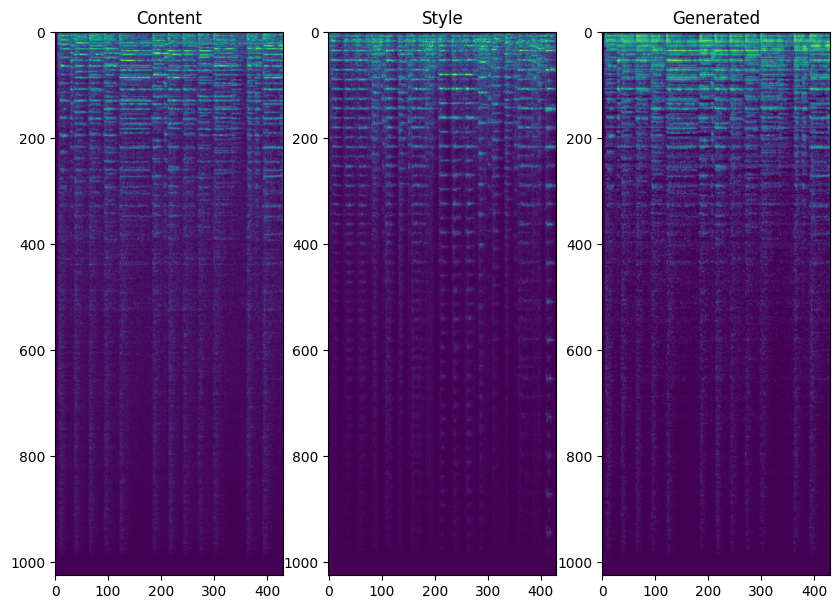

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.title("Content")
plt.imshow(content_img)

plt.subplot(1, 3, 2)
plt.title("Style")
plt.imshow(style_img)

plt.subplot(1, 3, 3)
plt.title("Generated")
plt.imshow(gen_img)

plt.show()

In [12]:
out_aud = Image_to_Audio(gen_img, mag_min, mag_max)
display(ipd.Audio(out_aud, rate=22050))

In [13]:
import soundfile as sf
sf.write('output_audio/test1.wav', out_aud, sr)

In [14]:
from audio_denoiser.AudioDenoiser import AudioDenoiser

denoiser = AudioDenoiser()

in_audio_file = 'output_audio/test1.wav'

out_audio_file = 'output_audio/clened1.wav'

denoiser.process_audio_file(in_audio_file, out_audio_file)

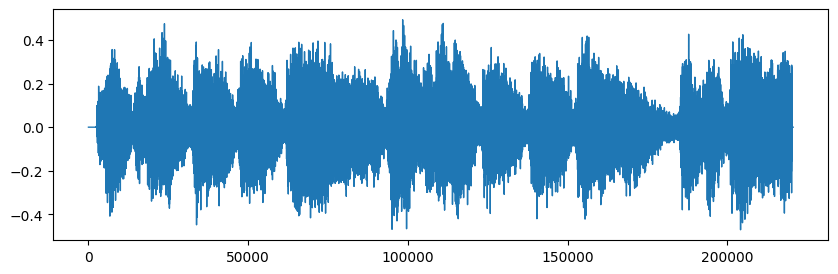

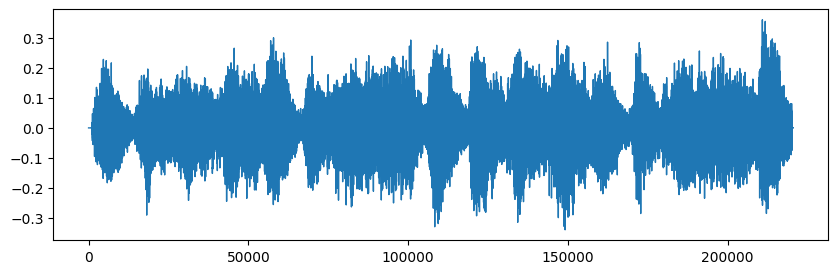

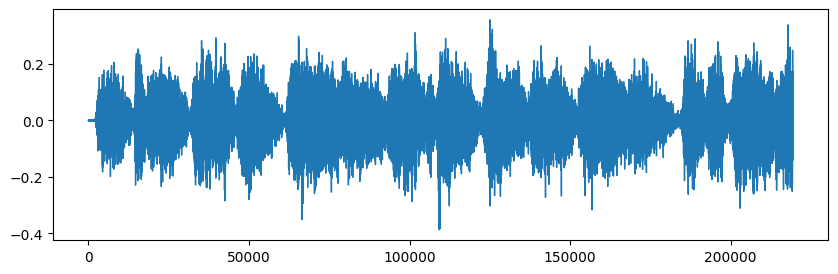

In [15]:
content, sr = audio_loader(content_path)
style, _ = audio_loader(style_path)
output_music, _ = audio_loader(out_audio_file)